# Gaussian Mixture Models
#### Math 3480 - Machine Learning - Dr. Michael E. Olson

## Reading
* Geron, Chapter 9

### Additional Resources
* [YouTube: Serrano Academy - Gaussian Mixture Models](https://www.youtube.com/watch?v=q71Niz856KE&t=630s)
  * Review: [YouTube: Serrano Academy - The Covariance Matrix](https://www.youtube.com/watch?v=WBlnwvjfMtQ)
 
## Applications
* Audio classification
* Document classification
* Image Segmentation

## Theory

GMMs are supervised models, but border on unsupervised.

We often see clusters very well defined. But they don't have to be. Consider a picture of Saturn:
![Saturn from Cassini satellite](https://science.nasa.gov/wp-content/uploads/2023/06/Saturn_captured_with_an_ethereal_glow_as_it_is_backlit_from_the_Sun-jpeg.webp?w=4096&format=png)

We can segment this image in three ways.
* The areas outside the planet and rings are outer space
* The ring
* The planet

You run a program to cluster the elements of the image. Pixels belonging to outer space is clustered nicely, and most of the rings and the planet are clustered respectively. But what about the area where the rings and the planet overlap?

__Hard clustering__ is where you weigh the probability of whether it is ring or planet and you cluster those pixels to the group with the highest probability.
* P(ring)=0.75, P(planet)=0.25   ==>   It's a ring
* Finds the group that best explains that point

__Soft clustering__ is where you weight the probability of whether it is a ring or planet and report the probability of each cluster
* P(ring)=0.75, P(planet)=0.25   ==>   75% chance it's a ring, 25% chance it's a planet
* All groups could contribute to explaining that point

Now, let's assume we have two groups. We create a gaussian distribution of those points.

<Axes: xlabel='Data'>

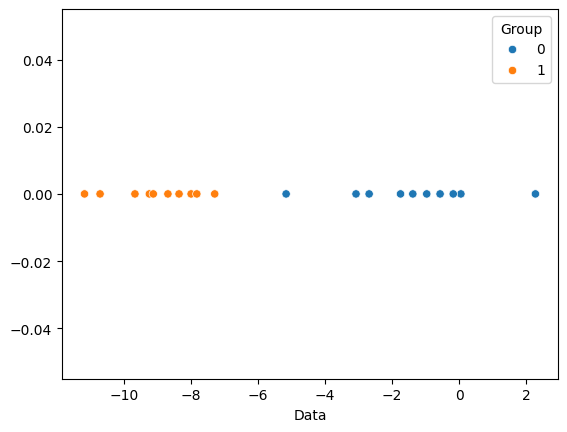

In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=20, n_features=1, centers=2, cluster_std=1.8,random_state=40)

X_df = pd.DataFrame(X,columns=['Data'])
X_df['Group'] = pd.DataFrame(y)

sns.scatterplot(data=X_df, x='Data', y=0, hue='Group')

<Axes: xlabel='Data', ylabel='Density'>

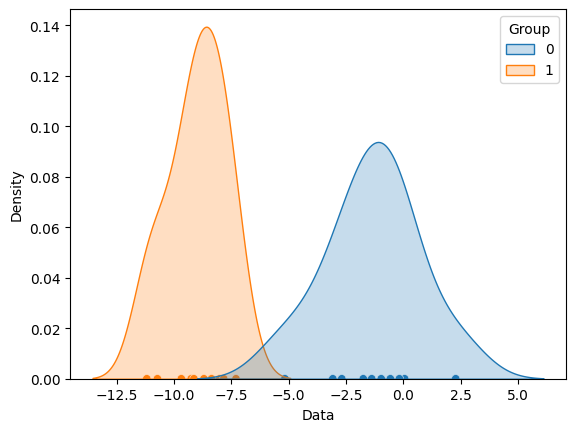

In [31]:
fig,ax = plt.subplots()
sns.scatterplot(data=X_df, x='Data', y=0, hue='Group', ax=ax)
sns.kdeplot(data=X_df, x='Data', hue='Group', fill=True, ax=ax)

Let's label these $f(x)$ for group 0 (blue) and $g(x)$ for group 1 (orange). The probability for a point $a$ would be,
$$P(f) = \frac{f(a)}{f(a)+g(a)} \qquad\qquad P(g) = \frac{g(a)}{f(a)+g(a)}$$

Now, how do we fit our data to a Gaussian curve? 
$$f(x)=\frac{1}{\sqrt{2\pi}\sigma}e^{-\tfrac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^2}$$

Let's switch to a 2-variable data at this point.
$$f(x)=\frac{exp(-\tfrac{1}{2}(x-\mu)^T \Sigma^{-1}(x-\mu))}{2\pi\sqrt{|\Sigma|}}$$

Where $\Sigma$ is the covariance matrix:
* x-variance
* y-variance
* covariance
$$\Sigma=\begin{bmatrix}
var(x) & cov(x,y) \\
cov(x,y) & var(y)
\end{bmatrix}$$




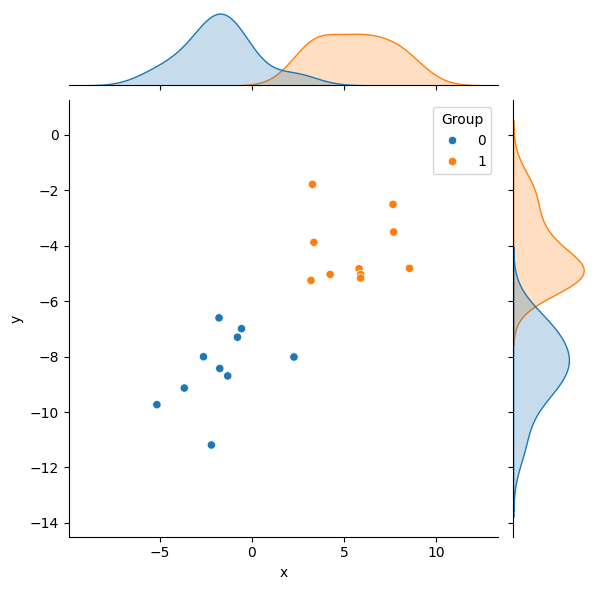

In [33]:
X, y = make_blobs(n_samples=20, n_features=2, centers=2, cluster_std=1.8,random_state=40)
X_df = pd.DataFrame(X,columns=['x','y'])
X_df['Group'] = pd.DataFrame(y)
sns.jointplot(data=X_df, x='x', y='y', hue='Group')

<Axes: xlabel='x', ylabel='y'>

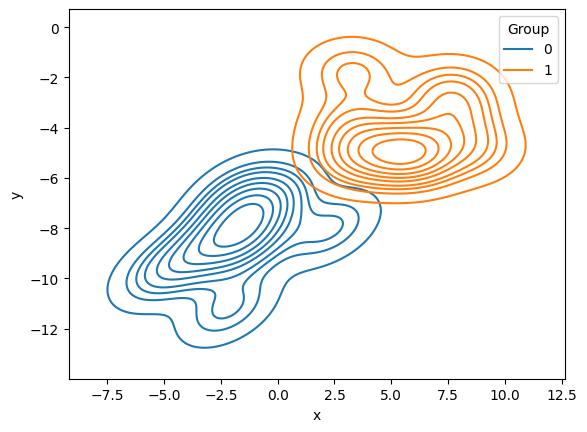

In [34]:
sns.kdeplot(data=X_df, x='x', y='y', hue='Group')

## Hard-clustering algorithm
First, we talk about the variance and covariance. Remember how we calculate them:

$$E[X] = \sum_{i=0}^{n-1}x_iP(x_i) \qquad var[X] = E[X^2] - E[X]^2$$
$$cov[X,Y] = E\left[(X-E[X])(Y-E[Y])\right] = \frac{\left<X-E[X],Y-E[Y]\right>}{n-1} = \frac{\left<\bar{X},\bar{Y}\right>}{n-1}$$

If each point is weighted equally, then $P(x_i) = 1/n$. So, the expected value is just the mean.
$$E[X] = \sum_{i=0}^{n-1}x_iP(x_i) = \frac{1}{n}\sum_{i=0}^{n-1}x_i$$

Once we have the variance and covariance, we can apply these to our gaussian curves as we wrote above.

#### Example of hard-clustering algorithm
Take the following points and calculate the variance and covariance:
|   x  |  y   |
|:---: |:---: |
| -24  | -12  |
|  -4  | -12  |
|  -4  |   8  |
|  26  |   8  |

$$E[X] = \frac{1}{4}(-24-4-4+26) = -1.5$$
$$\bar{x} = -1.5 \qquad \bar{y} = -2.0$$
$$\bar{X} = [-22.5, -2.5, -2.5, 27.5] \qquad \bar{Y} = [-10, -10, 10, 10]$$
$$var(x) = 425 \qquad var(y) = 133.33$$
$$cov(x,y) = \frac{\left<\bar{X},\bar{Y}\right>}{n-1} = \frac{225+25-25+275}{3} = 166.67$$

In [13]:
import numpy as np

x = np.array([-24,  -4, -4, 26])
y = np.array([-12, -12,  8,  8])

print(x.mean(), x-x.mean())
print(y.mean(), y-y.mean())
print(np.var(x, ddof=0), np.var(y, ddof=0))
print("\nThe Covariance Matrix")
print(np.cov(x,y, ddof=0))

-1.5 [-22.5  -2.5  -2.5  27.5]
-2.0 [-10. -10.  10.  10.]
318.75 100.0

The Covariance Matrix
[[318.75 125.  ]
 [125.   100.  ]]


The Gaussian Mixture Model will then follow this algorithm:
1. Start with random Gaussian curves
2. Find the probability of each point belong to each group
3. Recalculate the Gaussian curves based on the groupings in step 2
4. Repeat steps 2-3 until our curves stop changing

## Soft-clustering algorithm
If we do soft-clustering instead, then the points aren't assigned directly to a cluster, but are weighted toward a cluster. In other words, in our expected value,
$$E[X] = \sum_{i=0}^{n-1}x_iP(x_i)$$
the probability $P(x_i)$ is no longer 1/n. For example, in the same dataset, if we add a weight to each point,
|   x  |  y   |  w  |
|:---: |:---: |:---:|
| -24  | -12  | 0.4 |
|  -4  | -12  | 0.8 |
|  -4  |   8  | 0.7 |
|  26  |   8  | 1.0 |

$$E[X] = \sum_{i=0}^{n-1}x_iP(x_i) = (0.4)(-24) + (0.8)(-4) + (0.7)(-4) + (1.0)(26) = 10.4$$

This will then affect the variance and covariance calculations, which then affects the Gaussian Curve.

In [16]:
import numpy as np

x = np.array([-24,  -4, -4, 26])
y = np.array([-12, -12,  8,  8])
w = np.array([0.4, 0.8, 0.7, 1.0])

print(((x*w).sum())/w.sum())
print(((x*x*w).sum())/w.sum())

3.5862068965517233
320.8275862068965


Our algorithm is still the same. The only difference is the calculation of the Gaussian curves.
1. Start with random Gaussian curves
2. Find the probability of each point belong to each group
3. Recalculate the Gaussian curves based on the __weighted__ groupings in step 2
4. Repeat steps 2-3 until our curves stop changing

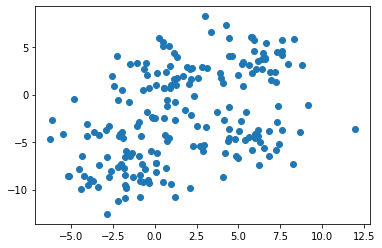

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=200, n_features=2, centers=5, cluster_std=1.8,random_state=40)
plt.scatter(X[:,0],X[:,1])

In [9]:
k = 5   # Number of Clusters

from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=k, n_init=10)
y_predict = gmm.fit_predict(X)

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y,y_predict))

[[ 0  0  0 40  0]
 [39  1  0  0  0]
 [ 1 26  5  8  0]
 [ 0  0 39  0  1]
 [ 1  0  4  0 35]]


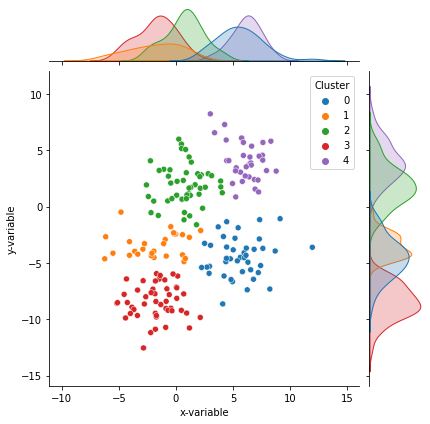

In [11]:
#dataset = pd.DataFrame([X,y_predict], columns=['A','B','Cluster'])
dataset = pd.DataFrame(X, columns=['x-variable','y-variable'])
dataset['Cluster'] = y_predict
sns.jointplot(data=dataset,x='x-variable',y='y-variable',hue='Cluster', palette='tab10')

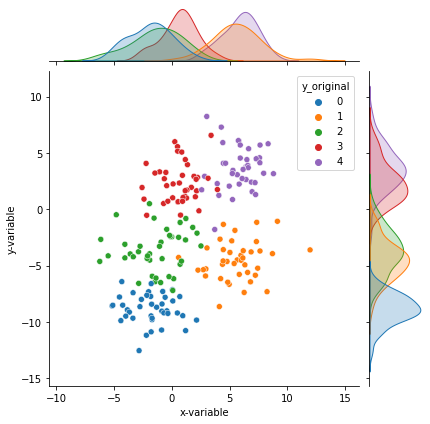

In [12]:
dataset['y_original'] = y
sns.jointplot(data=dataset,x='x-variable',y='y-variable',hue='y_original', palette='tab10')

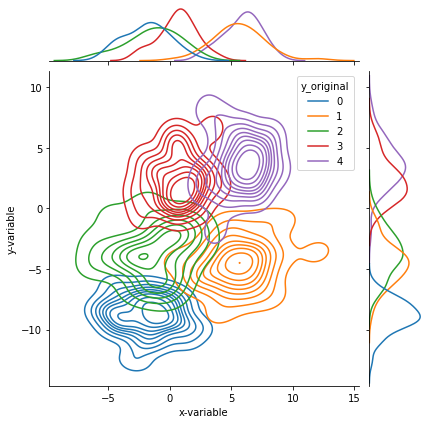

In [26]:
dataset['y_original'] = y
sns.jointplot(data=dataset,x='x-variable',y='y-variable', kind='kde', hue='y_original', palette='tab10')

<AxesSubplot:xlabel='x-variable', ylabel='y-variable'>

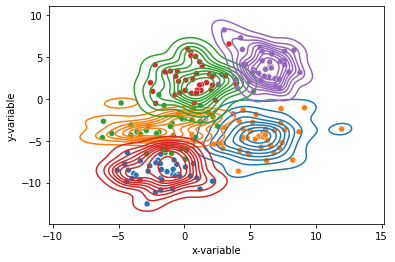

In [25]:
fig, ax = plt.subplots()
sns.kdeplot(data=dataset,x='x-variable',y='y-variable',hue='Cluster', palette='tab10', ax=ax, legend=False)
sns.scatterplot(data=dataset,x='x-variable',y='y-variable',hue='y_original', palette='tab10', ax=ax, legend=False)